### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (5,5)

### Neutron diffusion equation


The two-dimensional (2D) neutron equation is similar to the heat equation
$$
\frac{\partial \phi}{\partial t} = D \nabla^2 \phi
$$
only that we have an additional source term $\gamma N$. This is beacuase in the fission process, neutrons are released from splitting atoms. Our new equation will take the from
$$
\frac{\partial N}{\partial t} = D \nabla^2 N + \gamma N
$$
where $N$ is the neutron density and $\gamma$ is defined as 
$$
\frac{\mu - 1}{\tau} = \gamma
$$

where $\mu$ is the average number of neutrons released per fission and $\tau$ is the time between fissions. Since we are simply using the average value of $\mu$, this term will be treated as constant. Using the discretization of the Laplacian in 2D that we used in class, we have
$$
\frac{\partial N_{n_x,n_y}}{\partial t} \approx \frac{D}{\delta_x^2}\left[N_{n_x+1,n_y}
+N_{n_x-1,n_y}
+N_{n_x,n_y+1}
+N_{n_x,n_y-1}-4N_{n_x,n_y}\right]
+\gamma N_{n_x,n_y}
$$

Treating this using Euler's method, replacing

$$
\frac{\partial N_{n_x,n_y}}{\partial t} \approx \frac{N_{n_x,n_y}(t_m+\delta_t)-N_{n_x,n_y}(t_m)}{\delta_t}
$$

with some discrete time-step $\delta_t$ and setting $t_m = m\delta_t$. We now have the explicit iteration
$$
 N_{n_x,n_y}(t_{m+1}) = N_{n_x,n_y}(t_m)+ \frac{D \delta_t}{\delta_x^2}\left[N_{n_x+1,n_y}(t_m)
+N_{n_x-1,n_y}(t_m)
+N_{n_x,n_y+1}(t_m)
+N_{n_x,n_y-1}(t_m)-4N_{n_x,n_y}(t_m)\right]
+\delta_t\gamma N_{n_x,n_y}(t_m)
$$

In [2]:
@numba.njit
def diffusion_2d(N0,  # initial guess
                 bnd, # boundary
                 D,   # diffusion
                 δx,  # spacing-x
                 δt,  # spacing-t
                 nt,  # number of time steps
                 γ):  # source term coefficient
    
    counter = 0
    nx,ny = N0.shape
    N = np.zeros((nx,ny,nt))
    d = D*δt/δx**2
    N[:,:,0] = np.copy(N0)
    for it in range(1,nt):
        for ix in range(0,nx):
            for iy in range(0,ny):   
                if (bnd[ix,iy] == False):
                    N[ix,iy,it] = N[ix,iy,it-1] + d*(
                        N[(ix+1)%nx,iy,it-1]+
                        N[(ix-1)%nx,iy,it-1]+
                        N[ix,(iy+1)%ny,it-1]+
                        N[ix,(iy-1)%ny,it-1]-4*N[ix,iy,it-1]
                    ) + δt*γ*N[ix,iy,it-1]
                else:
                    N[ix,iy,it] = N[ix,iy,it-1]
    return N

For our first test case to see that the diffusion equation works, we will consider a simple sqaure. We first look at a system that is sub-critical, meaning that the number fo neutrons leaving through the edges is less than the number of neutrons being produced. In the early phases, we will consider the simple case of Dirichlet's boundary conditions, that is, where the number of neutrons at the edges is kept at zero.

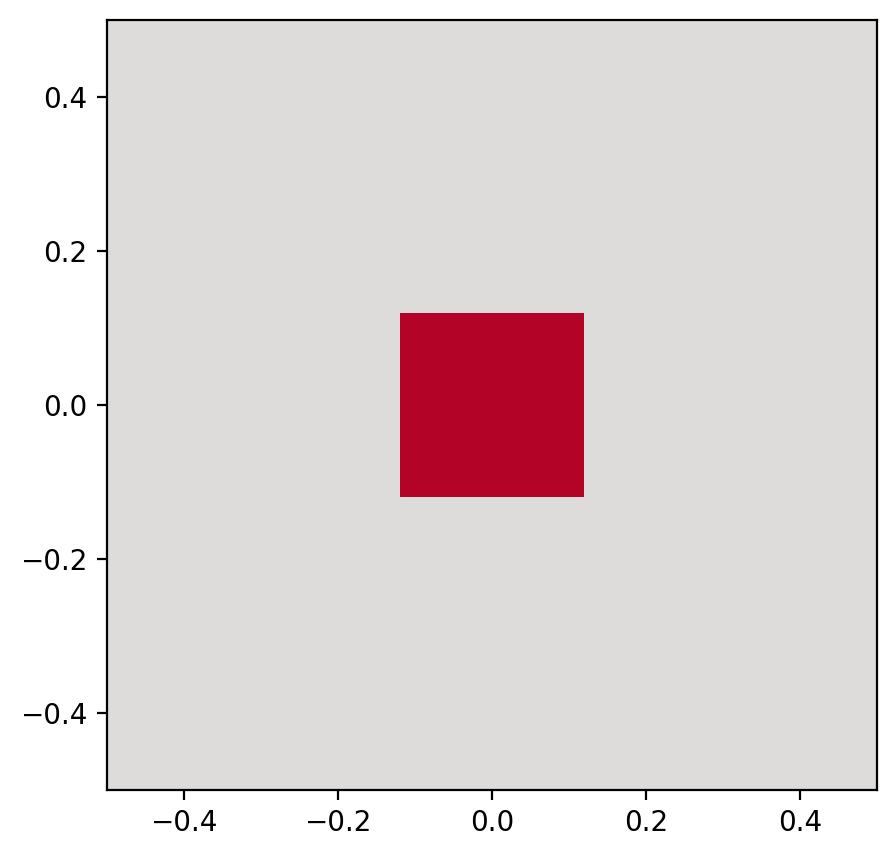

In [3]:
n = 100
N0 = np.zeros((n,n))
bnd = np.full((n,n),False,dtype=bool)
bnd[:,0] = bnd[:,-1] = True
bnd[0,:] = bnd[-1,:] = True

x = n//2
dx = n//8
N0[(x-dx):(x+dx),(x-dx):(x+dx)] = 1.0
plt.imshow(np.transpose(N0),extent=(-0.5,0.5,-0.5,0.5),origin='lower',cmap='coolwarm',vmin=-1,vmax=+1)

In [4]:
α = 0.1
D = 1.0
δx = 1.0/n
δt = δx**2/D*α
t1 = 0.1
nt = int(t1/δt)
γ = 3.0

Nd = diffusion_2d(N0, bnd, D, δx, δt, nt, γ)

In [5]:
@widgets.interact(t=(0.0,t1,δt))
def disp(t=0):
    it = int(t/t1*(nt-1))
    N = Nd[:,:,it]
    plt.imshow(np.transpose(N),extent=(-0.5,0.5,-0.5,0.5),cmap='coolwarm',origin='lower',vmin=-1,vmax=+1)
    plt.contour(np.transpose(N),levels=30,linewidths=0.5,colors='k',alpha=0.5,
            extent=(-0.5,0.5,-0.5,0.5),origin='lower')

interactive(children=(FloatSlider(value=0.0, description='t', max=0.1, step=1e-05), Output()), _dom_classes=('…

Taking out a slice, it levels out towards zero, as expected.

In [6]:
@widgets.interact(t = (0.0, t1, δt))
def disp(t = 0):
    it = int(t/t1*(nt - 1))
    N = Nd[:,:,it]
    Y = np.linspace(-0.5, 0.5, n)
    plt.ylim(0, 1.1)
    plt.xlim(-0.5, 0.5)
    plt.plot(Y, N[n//2,:])

interactive(children=(FloatSlider(value=0.0, description='t', max=0.1, step=1e-05), Output()), _dom_classes=('…

Now we can see what happens when the source term is large (by inceasing $\gamma$). The system becomes super-critical, meaning that the number of neutrons leaving the edges is less than the number of neutrons being produced

In [7]:
α = 0.1
D = 1.0
δx = 1.0/n
δt = δx**2/D*α
t1 = 0.1
nt = int(t1/δt)
γ = 55.0

Nd = diffusion_2d(N0, bnd, D, δx, δt, nt, γ)

In [8]:
@widgets.interact(t=(0.0,t1,δt))
def disp(t=0):
    it = int(t/t1*(nt-1))
    N = Nd[:,:,it]
    plt.imshow(np.transpose(N),extent=(-0.5,0.5,-0.5,0.5),cmap='coolwarm',origin='lower',vmin=-1,vmax=+1)
    plt.colorbar()
    plt.contour(np.transpose(N),levels=30,linewidths=0.5,colors='k',alpha=0.5,
            extent=(-0.5,0.5,-0.5,0.5),origin='lower')

interactive(children=(FloatSlider(value=0.0, description='t', max=0.1, step=1e-05), Output()), _dom_classes=('…

Taking out a slice, we can see it initially dies out, and then begins to grow very rapidly (this is the source term taking over, creating neutrons faster than they are being destroyed at the boundaries).

In [9]:
@widgets.interact(t = (0.0, t1, δt))
def disp(t = 0):
    it = int(t/t1*(nt - 1))
    N = Nd[:,:,it]
    Y = np.linspace(-0.5, 0.5, n)
    plt.ylim(0, 1.1)
    plt.xlim(-0.5, 0.5)
    plt.plot(Y, N[n//2,:])

interactive(children=(FloatSlider(value=0.0, description='t', max=0.1, step=1e-05), Output()), _dom_classes=('…

### Numerical Stability

We can be sure that our system "blowing up" is in fact caused by this super-critical state rather than numerical error since our stability condition is met, that is, $\alpha < 1/4$. We can see what happens when this isn't the case and our system is no longer numerically stable

In [10]:
α = 0.26
D = 1.0
δx = 1.0/n
δt = δx**2/D*α
t1 = 0.1
nt = int(t1/δt)
γ = 1.0

Nd = diffusion_2d(N0, bnd, D, δx, δt, nt, γ)

@widgets.interact(t=(0.0,t1,δt))
def disp(t=0):
    it = int(t/t1*(nt-1))
    N = Nd[:,:,it]
    plt.imshow(np.transpose(N),extent=(-0.5,0.5,-0.5,0.5),cmap='coolwarm',origin='lower',vmin=-1,vmax=+1)
    plt.colorbar()
    plt.contour(np.transpose(N),levels=30,linewidths=0.5,colors='k',alpha=0.5,
            extent=(-0.5,0.5,-0.5,0.5),origin='lower')

interactive(children=(FloatSlider(value=0.0, description='t', max=0.1, step=2.6000000000000002e-05), Output())…

In [11]:
@widgets.interact(t = (0.0, t1, δt))
def disp(t = 0):
    it = int(t/t1*(nt - 1))
    N = Nd[:,:,it]
    Y = np.linspace(-0.5, 0.5, n)
    plt.ylim(0, 1.1)
    plt.xlim(-0.5, 0.5)
    plt.plot(Y, N[n//2,:])

interactive(children=(FloatSlider(value=0.0, description='t', max=0.1, step=2.6000000000000002e-05), Output())…

### A more appropriate shape

Now we will consider a more accurate geometry. The demon core was two small hemispheres stacked one on top of the other, with a ring around the "equator" to prevent neutrons from jetting out of the sides. In this 2D case, we will consider two semi-circles with blocks at the edges where these semi-cirlces touch

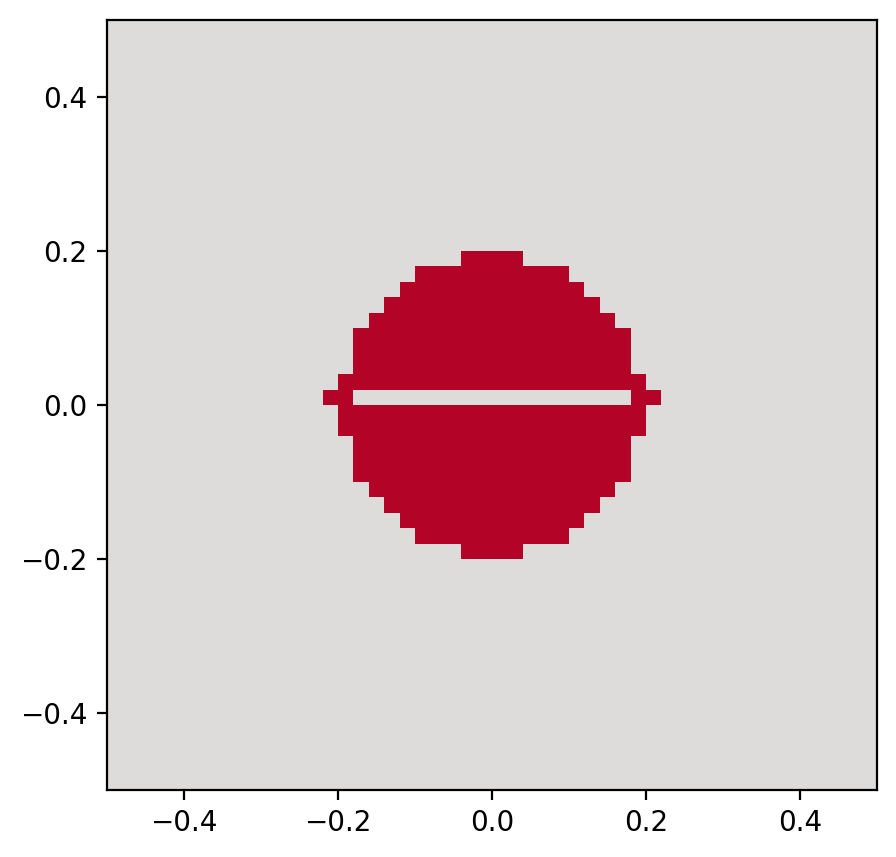

In [12]:
nx, ny = 50, 50

X,δx = np.linspace(-0.5,0.5, nx, retstep = True)
Y,δy = np.linspace(-0.5,0.5, ny, retstep = True)

mx,my = np.meshgrid(X,Y)

region = (mx/0.4)**2 + (my/0.4)**2 < 0.5**2

V = np.zeros((nx,ny))
V[region] = 1.0

V[:, ny//2] = 0 # taking a slice out
V[14:16,(nx//2):(nx//2+1)] = 1 # adding our left block
V[34:36,(nx//2):(nx//2+1)] = 1 # adding our right block

plt.imshow(np.transpose(V),extent=(-0.5,0.5,-0.5,0.5),
           origin='lower',cmap='coolwarm',vmin=-1,vmax=+1)

### Correcting dimensions

Given that the average number of neutrons emitted per fission of uranium 235 is 2.52, and the average time it takes for fission to occur is $10^{-8}s$, we can insert these into the definition of $\gamma$ and obtain a more reasonable value of

$$
\frac{2.52 - 1}{10^{-8}{\rm s}} = 1.52 \cdot 10^{8}s^{-1} = \gamma
$$

We will estimate the diffusion constant $D \approx 2.33 \cdot 10^{9} {\rm cm}^2/{\rm s}$. Since these values are quite large and may cause some memory allocation issues, we will rescale to $D = 1$ and $\gamma = 6.52\cdot10^{-2}$ by divinding both constants by the magnitude of $D$. 


### Defining new boundaries

We will assume that our boundaries are a thick box surrounding the core itself.

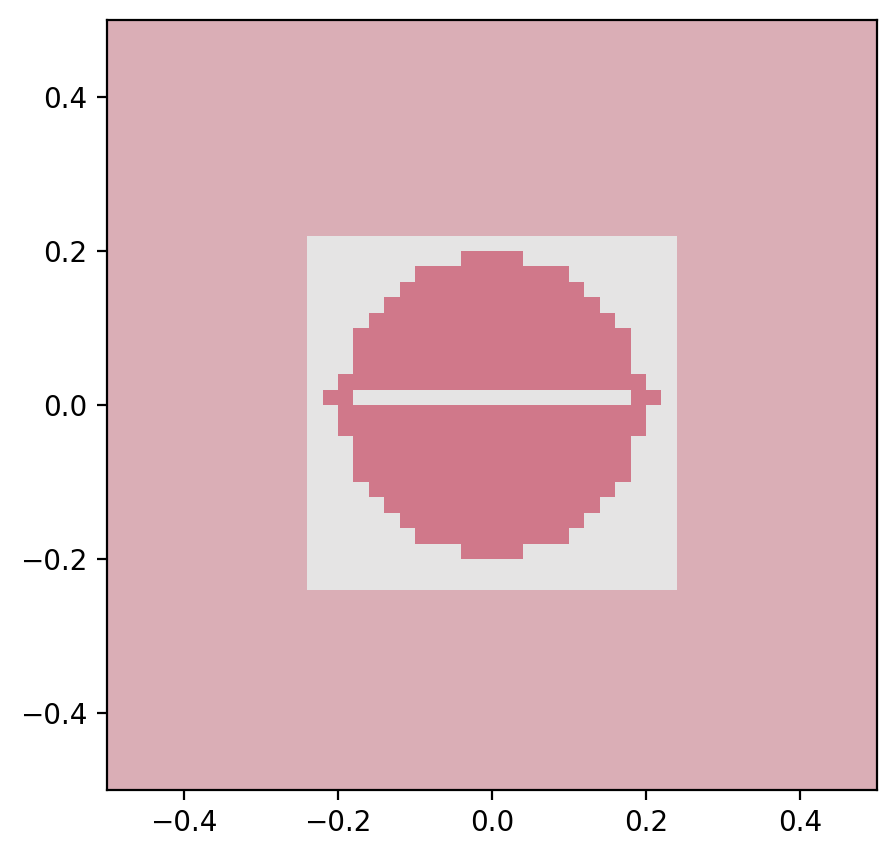

In [13]:
bnd = np.full((nx,ny), False, dtype=int)

size = nx//4

bnd[:,:] = 0

# Creating the void
bnd[0:size,:]  = 5 
bnd[3*size+2:50,:] = 5 
bnd[:,0:size]  = 5 
bnd[:,3*size+1:50] = 5 

bnd[size,size:3*size+1] = 1 # left side
bnd[3*size+1,size:3*size+1:] = 2 # right side
bnd[size:3*size+1,size] = 3 # bottom
bnd[size:3*size+1:,3*size] = 4 # top

B = np.zeros((nx,ny))
B = [bnd]

plt.imshow(np.transpose(B),extent=(-0.5,0.5,-0.5,0.5),
           origin='lower',cmap='coolwarm',vmin=-1,vmax=+1, alpha=0.5)
plt.imshow(np.transpose(V),extent=(-0.5,0.5,-0.5,0.5),
           origin='lower',cmap='coolwarm',vmin=-1,vmax=+1, alpha=0.5)

## Considering boundary conditions


### First boundary condition, Dirichlet

Applying the first boundary condition, we can see that the nuetrons are in fact destroyed at the boundary. With the given values, the core is sub-critical the deutron density will decay over time, reaching some steady state.

This will be simply be setting 

$$
N_{n_x,n_y}(t_{m+1}) = 0
$$

at the boundaries.

In [14]:
@numba.njit
def diffusion_2d_Dirichlet(N0,  # initial guess
                 bnd, # boundary
                 D,   # diffusion
                 δx,  # spacing-x
                 δt,  # spacing-t
                 nt,  # number of time steps
                 γ):  # source term coefficient
    
    counter = 0
    nx,ny = N0.shape
    N = np.zeros((nx,ny,nt))
    d = D*δt/δx**2
    N[:,:,0] = np.copy(N0)
    for it in range(1,nt):
        for ix in range(0,nx):
            for iy in range(0,ny):   
                if (bnd[ix,iy] == False):
                    N[ix,iy,it] = N[ix,iy,it-1] + d*(
                        N[(ix+1)%nx,iy,it-1]+
                        N[(ix-1)%nx,iy,it-1]+
                        N[ix,(iy+1)%ny,it-1]+
                        N[ix,(iy-1)%ny,it-1]-4*N[ix,iy,it-1]
                    ) + δt*γ*N[ix,iy,it-1]
                else:
                    N[ix,iy,it] = 0
    return N

In [15]:
α = 1e-1
D = 1
δt = δx**2/D*α
t1 = 7
nt = int(t1/δt)
γ = 6.52e-2

Nd = diffusion_2d_Dirichlet(V, bnd, D, δx, δt, nt, γ)

print(δt)

@widgets.interact(t=(0.0,t1,δt))
def disp(t=0):
    it = int(t/t1*(nt-1))
    N = Nd[:,:,it]
    plt.imshow(np.transpose(N),extent=(-0.5,0.5,-0.5,0.5),cmap='coolwarm',origin='lower',vmin=-1,vmax=+1)
    plt.colorbar()
    plt.contour(np.transpose(N),levels=30,linewidths=0.5,colors='k',alpha=0.5,
            extent=(-0.5,0.5,-0.5,0.5),origin='lower')

4.164931278633902e-05


interactive(children=(FloatSlider(value=0.0, description='t', max=7.0, step=4.164931278633902e-05), Output()),…

### Second boundary condition, Robin/mixed

Applying the Robin boundary condition, the neutrons will not be confined within the box surronding the core. They will be free to pass through. The end result should be similar to the Dirichlet boundary conditions, only it should take slightly longer to reach a steady state. For this step we will have to correct our solver for the diffusion equation to accomodate these new boudnaries.

This will be done by setting

$$
N_x = \frac{-2}{3}\frac{dN}{dx} ,  N_y = \frac{-2}{3}\frac{dN}{dy}
$$

Discretizing this for each side of our box: 

for the right side we get
$$
N_{n_x, n_y}(t_{m+1}) = \frac{2}{3}\frac{N_{n_{x-1}, n_y}(t_m) - N_{n_x, n_y}(t_m)}{\delta_x}
$$


for the left side we get
$$
N_{n_x, n_y}(t_{m+1}) = \frac{2}{3}\frac{N_{n_{x+1}, n_y}(t_m) - N_{n_x, n_y}(t_m)}{\delta_x}
$$


for the top we get
$$
N_{n_x, n_y}(t_{m+1}) = \frac{2}{3}\frac{N_{n_x, n_{y-1}}(t_m) - N_{n_x, n_y}(t_m)}{\delta_x}
$$


for the bottom we get
$$
N_{n_x, n_y}(t_{m+1}) = \frac{2}{3}\frac{N_{n_x, n_{y+1}}(t_m) - N_{n_x, n_y}(t_m)}{\delta_x}
$$

In [16]:
@numba.njit
def diffusion_2d_free(N0,  # initial guess
                 bnd, # boundary
                 D,   # diffusion
                 δx,  # spacing-x
                 δt,  # spacing-t
                 nt,  # number of time steps
                 γ):  # source term coefficient
    
    nx,ny = N0.shape
    N = np.zeros((nx,ny,nt))
    d = D*δt/δx**2
    N[:,:,0] = np.copy(N0)
    for it in range(1,nt):
        for ix in range(0,nx):
            for iy in range(0,ny):   
                if (bnd[ix,iy] == 0):
                    N[ix,iy,it] = N[ix,iy,it-1] + d*(
                        N[(ix+1)%nx,iy,it-1]+
                        N[(ix-1)%nx,iy,it-1]+
                        N[ix,(iy+1)%ny,it-1]+
                        N[ix,(iy-1)%ny,it-1]-
                        4*N[ix,iy,it-1]
                    ) + δt*γ*N[ix,iy,it-1]
                
                if (bnd[ix,iy] == 1): # left bnd
    
                    N[ix,iy,it] = (2/3)*(N[ix+1,iy,it-1] - N[ix,iy,it-1])
                    
                elif (bnd[ix,iy]==2): # right bnd
                    
                    N[ix,iy,it] = (2/3)*(N[ix-1,iy,it-1] - N[ix,iy,it-1])
                    
                elif (bnd[ix,iy] == 3 ): # bottom bnd
                   
                    N[ix,iy,it] = (2/3)*(N[ix,iy+1,it-1] - N[ix,iy,it-1])
                    
                elif (bnd[ix,iy] == 4): # top bnd
                   
                    N[ix,iy,it] = (2/3)*(N[ix,iy-1,it-1] - N[ix,iy,it-1])
                   
                    
    return N

In [17]:
α = 1e-1
D = 1
δt = δx**2/D*α
t1 = 7
nt = int(t1/δt)
γ = 6.52e-2

Nd = diffusion_2d_free(V, bnd, D, δx, δt, nt, γ)

print(δt)

@widgets.interact(t=(0.0,t1,δt))
def disp(t=0):
    it = int(t/t1*(nt-1))
    N = Nd[:,:,it]
    plt.imshow(np.transpose(N),extent=(-0.5,0.5,-0.5,0.5),cmap='coolwarm',origin='lower',vmin=-1,vmax=+1)
    plt.colorbar()
    plt.contour(np.transpose(N),levels=30,linewidths=0.5,colors='k',alpha=0.5,
            extent=(-0.5,0.5,-0.5,0.5),origin='lower')

4.164931278633902e-05


interactive(children=(FloatSlider(value=0.0, description='t', max=7.0, step=4.164931278633902e-05), Output()),…

### Replicating the incident's boundary conditions (Neumann)

During the second incident of the Demon Core, there were two halves of the reflecor, which were initially seperated, causing the core to be close to but slightly below criticality. During the experiment, the top half was dropped onto the bottom half, forming a completely closed relfective chamber, causing the system to become super-critical. We will simulate this "slightly open" geometry, were the relfectors are not quite touching. For this step we will have to correct our solver for the diffusion equation to accomodate these new boudnaries.

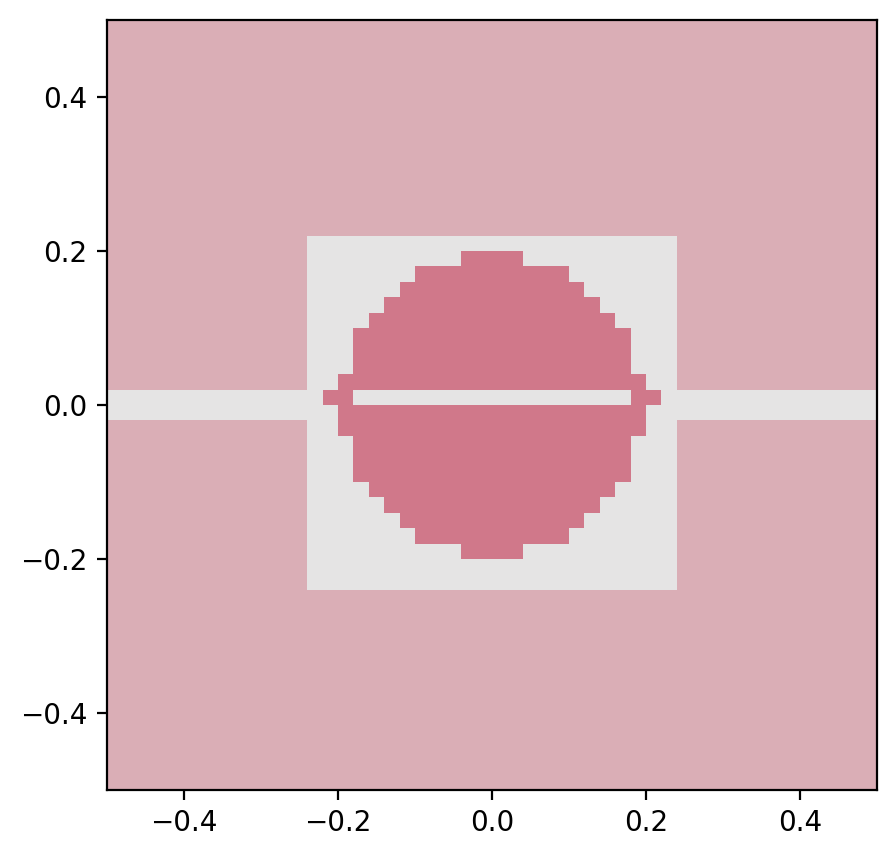

In [18]:
bnd = np.full((nx,ny), False, dtype=int)
bnd[:,:] = 0

size = nx//4

# Creating the void
bnd[0:size,:]  = 5 
bnd[3*size+2:50,:] = 5 
bnd[:,0:size]  = 5 
bnd[:,3*size+1:50] = 5 

bnd[size,size:3*size+1] = 1 # right side
bnd[3*size+1,size:3*size+1:] = 2 # left side
bnd[size:3*size+1,size] = 3 # bottom
bnd[size:3*size+1:,3*size] = 4 # top

bnd[:, ny//2-1: ny//2+1] = 0 # taking out a slice

B = np.zeros((nx,ny))
B = [bnd]

plt.imshow(np.transpose(B),extent=(-0.5,0.5,-0.5,0.5),
           origin='lower',cmap='coolwarm',vmin=-1,vmax=+1, alpha=0.5)
plt.imshow(np.transpose(V),extent=(-0.5,0.5,-0.5,0.5),
           origin='lower',cmap='coolwarm',vmin=-1,vmax=+1, alpha=0.5)

For this step we will have to correct our solver for the diffusion equation to accomodate these new boudnaries.

This will be done by setting 

$$
\frac{dN}{dx} = 0
$$

Discretizing this for each side of our box: 

for the right side we get
$$
N_{n_x, n_y}(t_{m+1}) = N_{n_{x-1}, n_y}(t_m)
$$


for the left side we get
$$
N_{n_x, n_y}(t_{m+1}) = N_{n_{x+1}, n_y}(t_m)
$$


for the top we get
$$
N_{n_x, n_y}(t_{m+1}) = N_{n_{x, n_{y-1}}}(t_m)
$$


for the bottom we get
$$
N_{n_x, n_y}(t_{m+1}) = N_{n_{x, n_{y+1}}}(t_m)
$$

In [19]:
@numba.njit
def diffusion_2d_reflector(N0,  # initial guess
                 bnd, # boundary
                 D,   # diffusion
                 δx,  # spacing-x
                 δt,  # spacing-t
                 nt,  # number of time steps
                 γ):  # source term coefficient
    
    nx,ny = N0.shape
    N = np.zeros((nx,ny,nt))
    d = D*δt/δx**2
    N[:,:,0] = np.copy(N0)
    for it in range(1,nt):
        for ix in range(0,nx):
            for iy in range(0,ny):   
                if (bnd[ix,iy] == 0):
                    N[ix,iy,it] = N[ix,iy,it-1] + d*(
                        N[(ix+1)%nx,iy,it-1]+
                        N[(ix-1)%nx,iy,it-1]+
                        N[ix,(iy+1)%ny,it-1]+
                        N[ix,(iy-1)%ny,it-1]-
                        4*N[ix,iy,it-1]
                    ) + δt*γ*N[ix,iy,it-1]
                
                if (bnd[ix,iy] == 1): # left bnd
    
                     N[ix,iy,it] = N[ix+1,iy,it-1]
                    
                elif (bnd[ix,iy]==2): # right bnd
                    
                    N[ix,iy,it] = N[ix-1,iy,it-1]
                    
                elif (bnd[ix,iy] == 3 ): # bottom bnd
                   
                  N[ix,iy,it] = N[ix,iy+1,it-1]
                    
                elif (bnd[ix,iy] == 4): # top bnd
                   
                    N[ix,iy,it] = N[ix,iy-1,it-1]
                   
                    
    return N

In [20]:
α = 1e-1
D = 1
δt = δx**2/D*α
t1 = 10
nt = int(t1/δt)
γ = 6.52e-2

Nd = diffusion_2d_reflector(V, bnd, D, δx, δt, nt, γ)

print(δt)

@widgets.interact(t=(0.0,t1,5*δt))
def disp(t=0):
    it = int(t/t1*(nt-1))
    N = Nd[:,:,it]
    plt.imshow(np.transpose(N),extent=(-0.5,0.5,-0.5,0.5),cmap='coolwarm',origin='lower',vmin=-1,vmax=+1)
    plt.colorbar()
    plt.contour(np.transpose(N),levels=30,linewidths=0.5,colors='k',alpha=0.5,
            extent=(-0.5,0.5,-0.5,0.5),origin='lower')

4.164931278633902e-05


interactive(children=(FloatSlider(value=0.0, description='t', max=10.0, step=0.0002082465639316951), Output())…

In [21]:
@widgets.interact(t=(0.0,t1,δt))
def disp(t=0):
    it = int(t/t1*(nt-1))
    N = (Nd[:,ny//2,it])
    plt.plot(N)
    plt.ylim(-0.2,1.1)

interactive(children=(FloatSlider(value=0.0, description='t', max=10.0, step=4.164931278633902e-05), Output())…

As we can see, the neutrons are able to escape out of the gap preventing the system from becoming super critical. We can see what the system would have looked like after the top reflector was dropped on the bottom reflector, effectly creating a closed reflecting chamber by closing this gap.

### Neumann (without gap)

Applying the Neumann boundary condition (with no gap), we can see that it behaves as a perfect reflector and the system will inevitably reach a super-critcal state as the neutron density will infinitely continue to increase over time. This resembles the boundary conditions after Dr Slotin's screwdriver slipped and the two halves of the reflectors made contact.

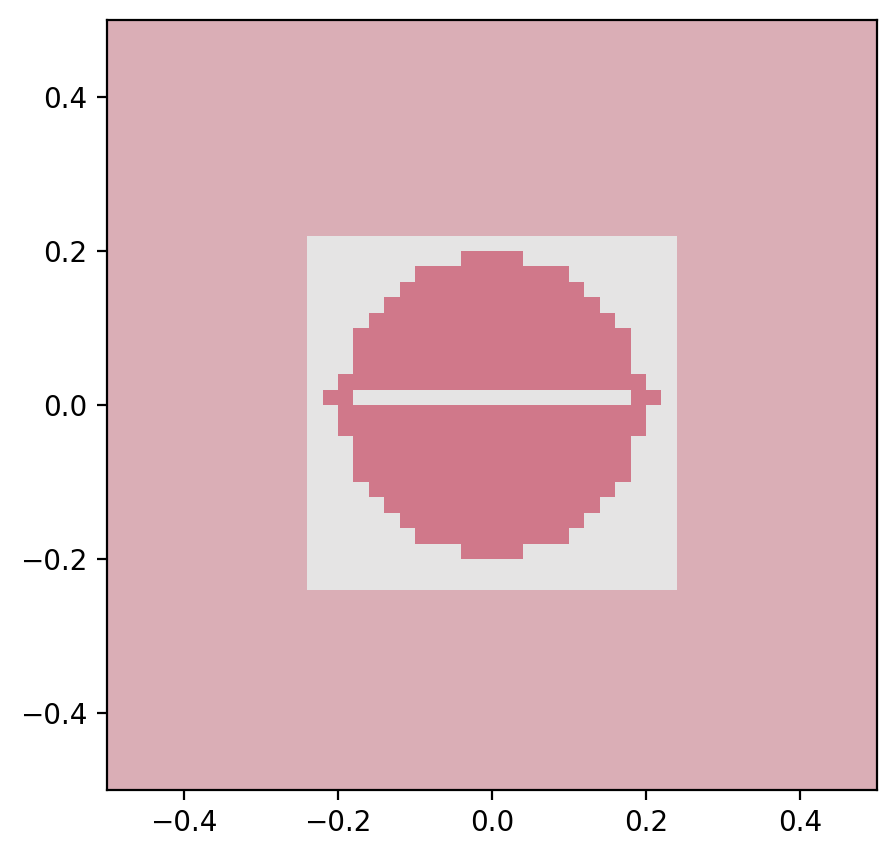

In [22]:
bnd = np.full((nx,ny), False, dtype=int)

size = nx//4

bnd[:,:] = 0

# Creating the void
bnd[0:size,:]  = 5 
bnd[3*size+2:50,:] = 5 
bnd[:,0:size]  = 5 
bnd[:,3*size+1:50] = 5 

bnd[size,size:3*size+1] = 1 # right side
bnd[3*size+1,size:3*size+1:] = 2 # left side
bnd[size:3*size+1,size] = 3 # bottom
bnd[size:3*size+1:,3*size] = 4 # top

B = np.zeros((nx,ny))
B = [bnd]

plt.imshow(np.transpose(B),extent=(-0.5,0.5,-0.5,0.5),
           origin='lower',cmap='coolwarm',vmin=-1,vmax=+1, alpha=0.5)
plt.imshow(np.transpose(V),extent=(-0.5,0.5,-0.5,0.5),
           origin='lower',cmap='coolwarm',vmin=-1,vmax=+1, alpha=0.5)

In [23]:
α = 1e-1
D = 1
δt = δx**2/D*α
t1 = 10
nt = int(t1/δt)
γ = 6.52e-2

Nd = diffusion_2d_reflector(V, bnd, D, δx, δt, nt, γ)

print(δt)

@widgets.interact(t=(0.0,t1,5*δt))
def disp(t=0):
    it = int(t/t1*(nt-1))
    N = Nd[:,:,it]
    plt.imshow(np.transpose(N),extent=(-0.5,0.5,-0.5,0.5),cmap='coolwarm',origin='lower',vmin=-1,vmax=+1)
    plt.colorbar()
    plt.contour(np.transpose(N),levels=30,linewidths=0.5,colors='k',alpha=0.5,
            extent=(-0.5,0.5,-0.5,0.5),origin='lower')

4.164931278633902e-05


interactive(children=(FloatSlider(value=0.0, description='t', max=10.0, step=0.0002082465639316951), Output())…

In [24]:
@widgets.interact(t=(0.0,t1,δt))
def disp(t=0):
    it = int(t/t1*(nt-1))
    N = (Nd[:,ny//2,it])
    plt.plot(N)
    plt.ylim(-0.2,1.1)

interactive(children=(FloatSlider(value=0.0, description='t', max=10.0, step=4.164931278633902e-05), Output())…